In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import midi_manipulation

#https://github.com/edouardtheron/py-midi

%matplotlib inline

In [3]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in tqdm(files):
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [4]:
#songs = get_songs('/Users/sdubnov/Documents/Courses/Mus 206 Deep & Shallow/Lab/Pop_Music_Midi/') #These songs have already been converted from midi to msgpack
songs = get_songs('./LABROSA-APT/train/MIDI')
print("{} songs processed".format(len(songs)))

100%|██████████| 19/19 [00:06<00:00,  2.83it/s]

19 songs processed


In [5]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 16 #16 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
n_hidden       = 100 #500 #3000 #1000 #500 #50 #This is the size of the hidden layer

num_epochs = 10000 #20000 #The number of training epochs that we are going to run. For each epoch we go through the entire data set.
batch_size = 100 #The number of training examples that we are going to send through the model at a time. 
#lr         = tf.constant(0.005, tf.float32) #The learning rate of our model

In [6]:
x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

In [7]:
z_dim = n_hidden #100
X_dim = n_visible #mnist.train.images.shape[1]
h_dim = n_hidden #128


In [8]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [9]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [10]:
def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

In [11]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

In [12]:
z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss) #check learning rate

#saver = tf.train.Saver()

W0814 18:16:04.222597 140736131625856 deprecation.py:323] From /anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Training is done here
you might be able to skip it if you have a previous checkpoint

Iter: 0
Loss: 1.163e+03


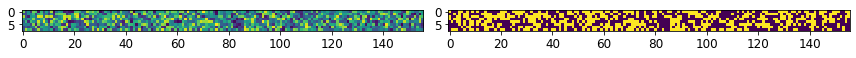

Iter: 1000
Loss: 119.1


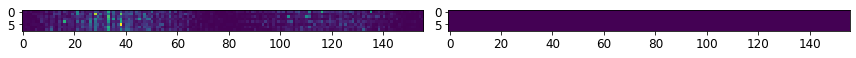

Iter: 2000
Loss: 123.6


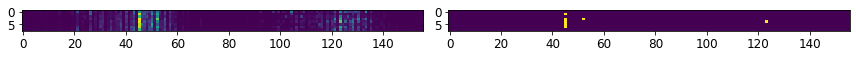

Iter: 3000
Loss: 63.43


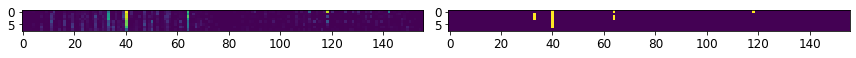

Iter: 4000
Loss: 85.13


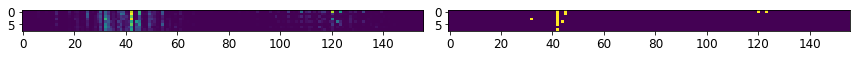

Iter: 5000
Loss: 69.02


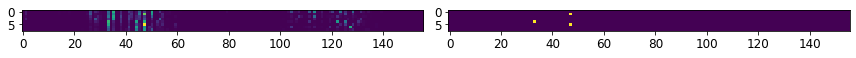

Iter: 6000
Loss: 69.94


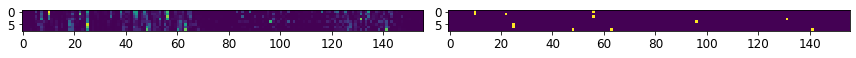

Iter: 7000
Loss: 74.22


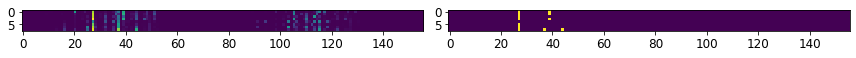

Iter: 8000
Loss: 43.59


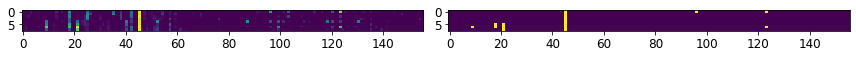

Iter: 9000
Loss: 72.13


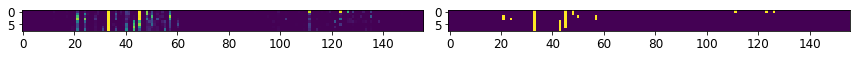

Iter: 10000
Loss: 88.78


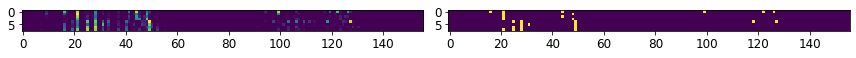

In [663]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

while i <= num_epochs:
    for song in songs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
        # Train the VAE on batch_size examples at a time
        for ind in range(1, len(song), batch_size): 
            X_mb = song[ind:ind+batch_size]
            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
    
            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                print('Loss: {:.4}'. format(loss))

                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})

                S = np.reshape(samples, (num_timesteps, 2*note_range))
                thresh_S = S>=0.5
                plt.figure(figsize=(12,2))
                plt.subplot(1,2,1)
                plt.imshow(S)
                plt.subplot(1,2,2)
                plt.imshow(thresh_S)
                plt.tight_layout()
                plt.pause(0.1)
                midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
#                 print(i)
            i += 1

In [664]:
#Save the model
saver = tf.train.Saver()

ckptfilename = './t'+str(num_timesteps)+'h'+str(n_hidden)+'.ckpt'
save_path = saver.save(sess, ckptfilename)

#save_path = saver.save(sess, "/tmp/model3000.ckpt")
#save_path = saver.save(sess, "/tmp/model500.ckpt") #this is h=500
#save_path = saver.save(sess, "/tmp/modelt32h3000.ckpt") #this is h=500
print("Model saved in path: %s" % save_path)

Model saved in path: ./t8h100.ckpt


## Having trained the VAE, we can now create a new piece from a random latent seqeunce z

In [13]:
sess = tf.Session()
saver = tf.train.Saver()
ckptfilename = './t'+str(num_timesteps)+'h'+str(n_hidden)+'.ckpt'

#saver.restore(sess, "/tmp/model3000.ckpt")
#saver.restore(sess, "/tmp/model.ckpt")
#saver.restore(sess, "/tmp/modelt32h3000.ckpt")
saver.restore(sess, ckptfilename)
print("Model restored ", ckptfilename)

Model restored  ./t16h500.ckpt


In [14]:
n_visible

2496

In [15]:
n_hidden

500

### Test generaion from a random seqeunce of latent states z. 

In [689]:
bars = 60
samples = sess.run(X_samples, feed_dict={z: np.random.randn(bars,z_dim)})
S = np.reshape(samples, (bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_long")

### Switching from VAE training to single shot VMO 
Up till now the VAE model was trained to reproduce individual music blocks (bars or longer) and generate new improvisation by random sampling from the latent space z.

Now we use a different midi file to create a sequence of latent variables z and model it with VMO
We also add a bit-rate control / data reduction of the z sequence


In [16]:
#q = "./Naruto Shippuden OP 16 COMP - C maj.mid"
#q = "./tmprson3.mid"
#q = "./Naruto Shippuden OP 16 COMP.mid"
#q = "./Pop_Music_Midi/All The Small Things - Verse.midi"
q = './LABROSA-APT/test/MIDI/bach_847MINp_align.mid'
querysong = np.array(midi_manipulation.midiToNoteStateMatrix(q))
print(np.shape(querysong))

(1105, 156)


In [17]:
song = np.array(querysong)
song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
print(np.shape(song))

(69, 2496)


### Encoding-Decoding based generation:
We encode and decode the query using VAE. The encoding process creates a sequence of latent states that are used as an input to decoder that generates new music "in the style" of the VAE training data.

In [18]:
# Encode the VAE on query
Xq = song
zq_sample, zq_mu, zq_logvar = sess.run([z_sample, z_mu, z_logvar], feed_dict={X: Xq}) 
#zq_sample = sess.run(z_sample, feed_dict={X: Xq}) 
#using the mean instead of sampling: 
#zq_sample = sess.run(z_mu, feed_dict={X: Xq})  #Check why this causes breaks / missing values in the output

(69, 500)


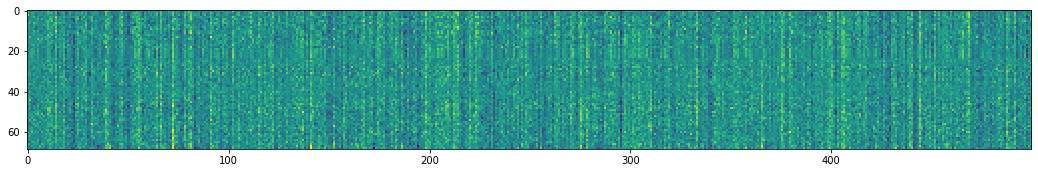

In [19]:
plt.figure(figsize=(18,5))
#plt.imshow(np.log(np.abs(zq_sample)))
plt.imshow(zq_mu)
print(np.shape(zq_sample))

In [20]:
# Decode with the z from query
samples = sess.run(X_samples, feed_dict={z: zq_sample})
decode_bars = np.shape(song)[0]
S = np.reshape(samples, (decode_bars*num_timesteps, 2*note_range))
thresh_S = S>=0.3 #0.5 #0.7
outfname = 'out/generated_query_t'+str(num_timesteps)+'h'+str(n_hidden)
midi_manipulation.noteStateMatrixToMidi(thresh_S, outfname)
#midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_query_h500_nt16")
#midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_query_h3000_nt16")
outfname

'out/generated_query_t16h500'

(69, 500)


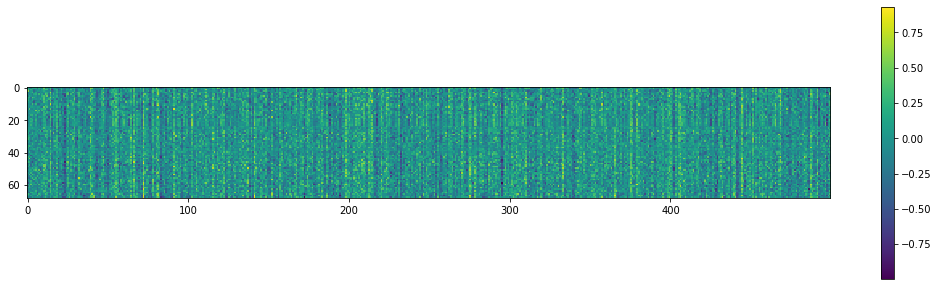

In [21]:
plt.figure(figsize=(18,5))
#plt.imshow(np.log(np.abs(zq_sample)))
plt.imshow(zq_mu)
print(np.shape(zq_mu))
plt.colorbar()

(69, 500)


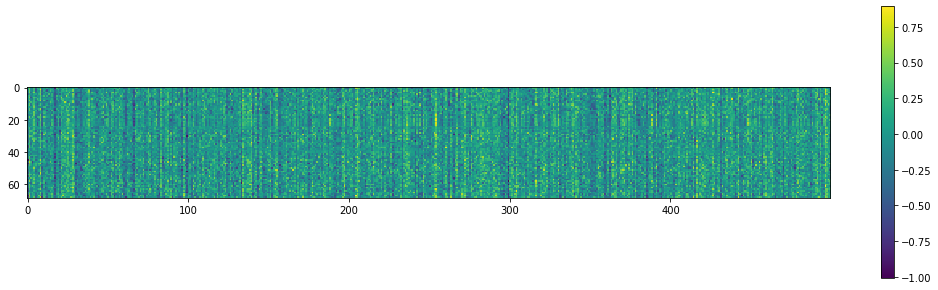

In [22]:
plt.figure(figsize=(18,5))
#plt.imshow(np.log(np.abs(zq_sample)))
plt.imshow(zq_logvar)
print(np.shape(zq_logvar))
plt.colorbar()

(69, 500)


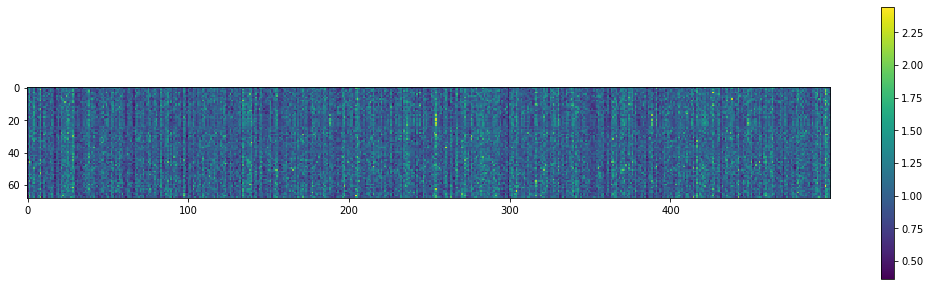

In [23]:
plt.figure(figsize=(18,5))
zq_sig2 = np.exp(zq_logvar)
#plt.imshow(np.log(np.abs(zq_sample)))
plt.imshow(zq_sig2)
print(np.shape(zq_sig2))
plt.colorbar()


# FINDING ORACLE FOR LATENT STATES
In the following cells we will use zq_sample as our features and try to find VMO to this data. The idea is to test if the feature learning aspect of VMO actually carries temporal information. The figure above has time as vertical and feature index as horizontal

In [24]:
import vmo
r = (0., 2.0, 0.01)
#ideal_t = vmo.find_threshold(zq_sample.T, r = r, dfunc = 'euclidean', dim=zq_sample.shape[0])
ideal_t = vmo.find_threshold(zq_sample, r = r, dim=zq_sample.shape[1])
#ideal_t = vmo.find_threshold(zq_mu, r = r, dim=zq_sample.shape[1])

In [25]:
ideal_t[0][0]

71.81489950679291

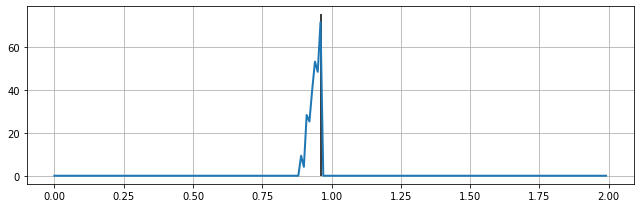

In [26]:
x_t = np.array([t[1] for t in ideal_t[1]])
y_t = [t[0] for t in ideal_t[1]] 
plt.figure(figsize = (9,3))
plt.plot(x_t, y_t, linewidth = 2)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t[0][1], 0, ymax)
plt.grid('on')
plt.tight_layout()

In [27]:
best_zq_oracle = vmo.build_oracle(zq_sample, flag = 'a', threshold = ideal_t[0][1], dim=zq_sample.shape[1])
#best_zq_oracle = vmo.build_oracle(zq_mu, flag = 'a', threshold = ideal_t[0][1], dim=zq_sample.shape[1])

### Creating an improvised version from the query latent sequence

In [28]:
print(np.shape(zq_sample))

(69, 500)


In [35]:
import vmo.analysis as van
import vmo.generate as vge

bo = best_zq_oracle

b, kend, ktrace = vge.generate(bo, 120, 0.87, 1, LRS=2, weight='weight')
seq = [zq_sample[i-1] for i in b]

In [36]:
print(b)

[2, 3, 4, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 36, 37, 38, 39, 40, 41, 42, 43, 44, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 26, 66, 67, 69, 1, 2, 3, 4, 44, 58, 59, 60, 61, 62, 63, 64, 38, 39, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 1, 2, 3, 4, 44, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 1, 2, 3, 4, 5, 6, 56, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 1, 2, 3, 4]


In [37]:
help(vge.generate)

Help on function generate in module vmo.generate:

generate(oracle, seq_len, p=0.5, k=1, LRS=0, weight=None)
    Generate a sequence based on traversing an oracle.
    
    :param oracle: a indexed vmo object
    :param seq_len: the length of the returned improvisation sequence
    :param p: a float between (0,1) representing the probability using the forward links.
    :param k: the starting improvisation time step in oracle
    :param LRS: the length of minimum longest repeated suffixes allowed to jump
    :param weight:
            None: choose uniformly among all the possible sfx/rsfx given
                current state.
            "max": always choose the sfx/rsfx having the longest LRS.
            "weight": choose sfx/rsfx in a way that favors longer ones than
            shorter ones.
    :return:
            s: a list containing the sequence generated, each element represents a
            state.
            kend: the ending state.
            ktrace:



In [38]:
# Decode with the z from query
#samples = sess.run(X_samples, feed_dict={z: zq_sample}) #this is reconstruction from the query latent sequence
samples = sess.run(X_samples, feed_dict={z: seq}) #this is reconstructio (decoding) from improvised latent sequence
decode_bars = len(samples)
S = np.reshape(samples, (decode_bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
fname = 'out/generated_query_h500_nt16_Full' #Full rate
#fname = 'out/generated_query_h3000_nt16_Full' #Full rate
midi_manipulation.noteStateMatrixToMidi(thresh_S,fname )    

### TO DO

right now the distance is measured between the means only. The feature vector shoud be the pair (mu, logvar)
here is what needs to be done-
1. create a combined (mu, logvar) feature 
2. add kl_loss as a distance measure in vmo

kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

here is a nice derivation of the kl distance for two Guassians
https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians


### IR for latent states as function of time
This gives a very high level qualitative impression about the way repetitions are detected. First there are new stuates with no repetitions, then two short repretitions and two longer ones (the hight shows IR value, which is proportional to the length of repeated block. Longer repeated blocks give higher IR).
This could be compared to IR of the original data to see if the signal itself has similar behavior. 

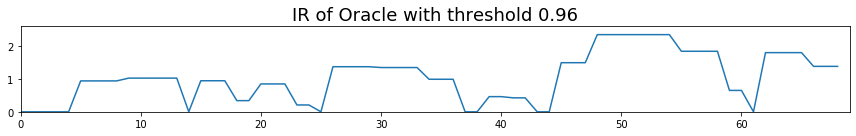

In [29]:
ir, h0, h1 = best_zq_oracle.IR()
plt.figure(figsize=(12,2))
plt.plot(ir)
plt.ylim((0, max(ir) + 0.25))
plt.xlim((0, len(ir)))
plt.title('IR of Oracle with threshold' + ' ' + str(ideal_t[0][1]), fontsize=18)
plt.tight_layout()

## trying to see if self-similairty matrixs can visually reveal the structure

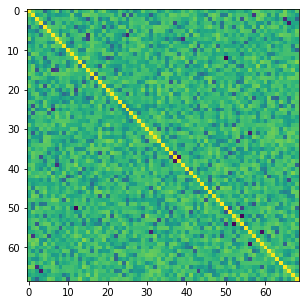

In [30]:
plt.figure(figsize=(5,5))
#z_selfsim= np.matmul(zq_mu,zq_mu.T)
z_selfsim= np.matmul(zq_sample,zq_sample.T)
plt.imshow(np.log2(np.abs(z_selfsim)))

### Cross correlation between the latent variables. 
This is done to jsut to see if the latent dimensions are independent.

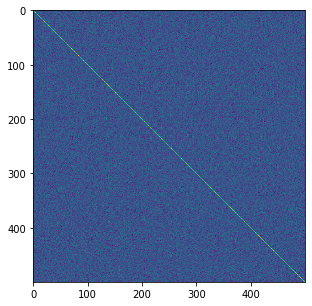

In [31]:
plt.figure(figsize=(5,5))
z_corrmat= np.matmul(zq_sample.T,zq_sample)
#z_corrmat= np.corrcoef(zq_mu.T)
plt.imshow(z_corrmat)

### Plotting the latent vectors statistics: Mean and Variance

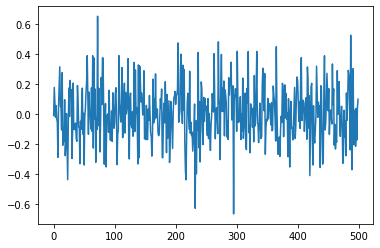

In [32]:
zq_mu = np.mean(zq_sample,axis = 0)
plt.plot(zq_mu)

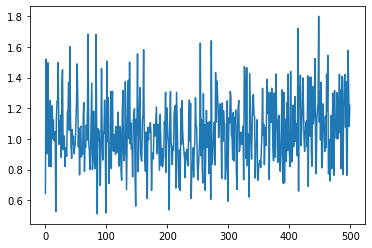

In [33]:
zq_sig2 = np.var(zq_sample,axis=0)
plt.plot(zq_sig2)

# Reducing the bit-rate of latent states 
The experiment is described in Mume paper. The idea is to control the information rate between the input and the latent state before passing it to the decoder. The idea of bit-allocation is used to have quantitative control of the amount of information, but basically the process removes latent dimensions that have little energy (variance) and adds noise to the other dimensions, depending on the total number of bits allowed. 

### Rate control:
Rate is the value allowing to control the noisy channel model of limiting information rate between latent states and input. See the Mume paper.

In [34]:
def reverse_water_filling(sigma2,bit_regime):
    bit_alloc = np.zeros(len(sigma2))
    tmp_s = 0
    tmp_s += sigma2
    for i in range(bit_regime):
        j = np.argmax(tmp_s)
        bit_alloc[j] += 1
        tmp_s[j] /= 4
    return bit_alloc

### Here equations of optimal channel (Berger) are implemented
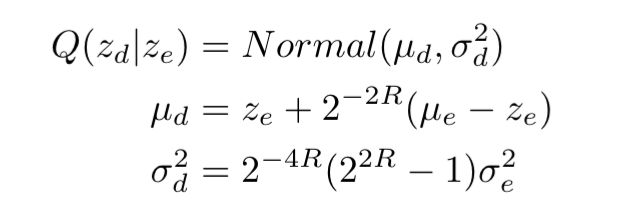

In [35]:
#Passing the original zq_sample except for bins that received zero bits
#quant_zq = zq_sample[:,np.nonzero(bit_alloc)[0]]
#quant_zq = np.zeros(np.shape(zq_sample))
#quant_zq[:,np.nonzero(bit_alloc)[0]] = zq_sample[:,np.nonzero(bit_alloc)[0]]

In [36]:
def Berger(zq_sample, bit_alloc):
           
    chan_mumul = (1-np.power(2,-2*bit_alloc))
    chan_sig2mul = np.power(2,-4*bit_alloc)*(np.power(2,2*bit_alloc)-1)
    chan_eps = np.random.randn(*np.shape(zq_sample))

    #Assuming zero mean and unit variance for the encoder Z:
    #quant_zq = np.matmul(zq_sample,np.diag(chan_mumul)) + np.matmul(chan_eps,np.diag(chan_sigmul)) 

    #Using the actual mean and variance of the encoder Z:
    quant_zq = np.matmul(zq_mu, np.diag(np.power(2,-2*bit_alloc))) + \
    np.matmul(zq_sample,np.diag(chan_mumul)) + \
    np.matmul(np.matmul(chan_eps,np.diag(np.sqrt(chan_sig2mul))),np.diag(np.sqrt(zq_sig2)))
    return quant_zq

## Comparison of the latent states before and after bit-allocation

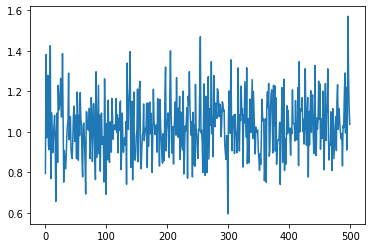

In [37]:
zq_sig2 = np.mean(np.exp(zq_logvar), axis = 0)
plt.plot(zq_sig2)

float32
float64


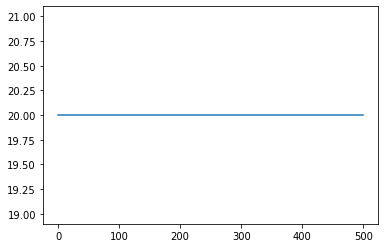

In [163]:
Rate = 10000
bit_alloc = reverse_water_filling(zq_sig2,Rate)
plt.plot(bit_alloc)
#print np.nonzero(bit_alloc)
quant_zq = Berger(zq_sample, bit_alloc)  #quantisation
print(zq_sample.dtype)
print(quant_zq.dtype)

#### Note:
Here we replace the empirical variance computed from zq_sample with the zq_logvar feature.
We also average over all time steps to get the average variance for each channel

There are some open questions here:
1. the empirically derived zq_sig2 by estimating variance of zq_sample and the one below that is calculated directly from zq_logvar look different. Why? check / debug
2. change the bit allocation to be dynamic frame per frame. There is no reason to do an average bit allocation if we can switch between frames. 

It does seem from the graph of logvar over time that the variance does not change much, so at east for this data I do not expect much change, but potentially if the music changed and this is refected in changes to the latent states, the bit allocation trick could be a method to reveal that by focusing on the important high variance channels

Although we changed the orace creation above to use z_mu, the actual experiment of encoding / deconding did not change. We still need to use the sampling method from the reparametrization trick to create the decoding, and we apply the noisy channel / bit allocation trick to these latent variables before decoding. What it does open up as an interesting possibiility is using a query from vmo to find now longer sequences of latent feature from a query before the decoding samping phase is performed.

(69, 500) (69, 500)


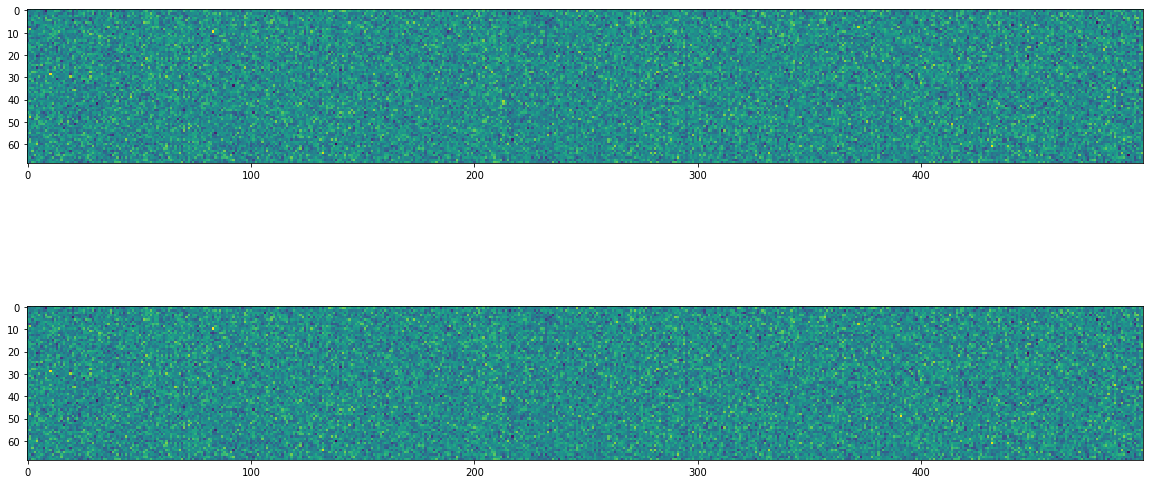

In [164]:
print(np.shape(quant_zq), np.shape(zq_sample))
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(zq_sample)
plt.subplot(2,1,2)
plt.imshow(quant_zq)

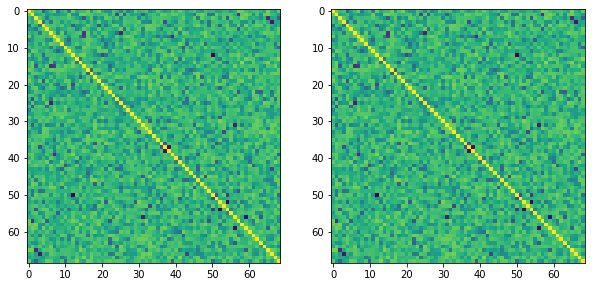

In [165]:
plt.figure(figsize=(10,10))


plt.subplot(1,2,1) 
z_selfsim= np.matmul(zq_sample,zq_sample.T)
plt.imshow(np.log2(np.abs(z_selfsim)))

plt.subplot(1,2,2) 
quant_z_selfsim= np.matmul(quant_zq,quant_zq.T)
plt.imshow(np.log2(np.abs(quant_z_selfsim)))

### Estimation of MI using MINE
Keras implementation with two layers, dropout and learning rate reduction

In [166]:
from tensorflow import keras
from tensorflow.keras import layers
H = 20

dim_n = n_hidden
#randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

input_A = keras.layers.Input(shape=[2*dim_n])
input_B = keras.layers.Input(shape=[2*dim_n])
    
transform = keras.models.Sequential([
layers.Dense(H, kernel_initializer='random_normal', activation="relu"),
keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(H, kernel_initializer='random_normal', activation="relu"),
keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(1, kernel_initializer='random_normal', activation=None)])

output_A = transform(input_A)
output_B = transform(input_B)
output_C = tf.reduce_mean(output_A) - tf.math.log(tf.reduce_mean(tf.exp(output_B))) # MINE
#output_C = tf.reduce_mean(output_A) - tf.reduce_mean(tf.exp(output_B))+1 # MINE-f
MI_mod = keras.models.Model(inputs=[input_A, input_B], outputs=output_C)

def loss_func(inp, outp):
    '''Calculate the loss: scaled negative estimated mutual information'''
    return -outp

MI_mod.compile(loss=loss_func, optimizer=keras.optimizers.Nadam(lr=0.0001))

In [174]:
print(MI_mod.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 1000)]       0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 1)            20461       input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Exp_13 (TensorFlowO [(None, 1)]          0           sequential_10[1][0]       

In [167]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

x_in=quant_zq[:-1,:].astype('float32')
y_in=zq_sample[1:,:]       
y_shuffle = tf.random_shuffle(y_in)
print(np.shape(x_in))
print(np.shape(y_in))
print(np.shape(y_shuffle))
print(x_in.dtype)
print(y_in.dtype)
print(y_shuffle.dtype)

batch_size=1
steps = np.shape(x_in)[0]//batch_size
print(steps)
joint_sample = tf.concat([x_in, y_in], axis=1)
marg_sample = tf.concat([x_in, y_shuffle], axis=1)
print(np.shape(joint_sample))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.00001)

history_mi = MI_mod.fit((joint_sample, marg_sample), joint_sample, callbacks=[reduce_lr], steps_per_epoch = steps, epochs=200, batch_size=batch_size)

(68, 500)
(68, 500)
(68, 500)
float32
float32
<dtype: 'float32'>
68
(68, 1000)
Train on 68 samples
Epoch 1/200
68/68 [==============================] - 1s 15ms/step - loss: -0.0024
Epoch 2/200
68/68 [==============================] - 0s 3ms/step - loss: -0.0192
Epoch 3/200
68/68 [==============================] - 0s 3ms/step - loss: -0.0438
Epoch 4/200
68/68 [==============================] - 0s 3ms/step - loss: -0.0915
Epoch 5/200
68/68 [==============================] - 0s 3ms/step - loss: -0.1934
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: -0.3953
Epoch 7/200
68/68 [==============================] - 0s 3ms/step - loss: -0.7095
Epoch 8/200
68/68 [==============================] - 0s 3ms/step - loss: -1.1311
Epoch 9/200
68/68 [==============================] - 0s 3ms/step - loss: -1.6638
Epoch 10/200
68/68 [==============================] - 0s 4ms/step - loss: -2.1347
Epoch 11/200
68/68 [==============================] - 0s 4ms/step - loss: -2.5897
Epoch 1

68/68 [==============================] - 0s 3ms/step - loss: -5.6426
Epoch 198/200
68/68 [==============================] - 0s 3ms/step - loss: -6.1232
Epoch 199/200
68/68 [==============================] - 0s 3ms/step - loss: -5.8006
Epoch 200/200
68/68 [==============================] - 0s 3ms/step - loss: -6.0645


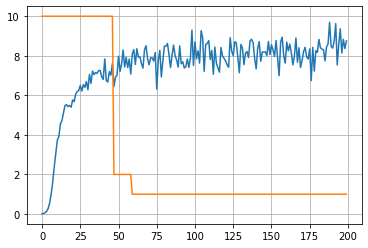

8.74924094573494


In [168]:
mi = np.log2(np.exp(1))*np.abs(history_mi.history['loss']) # scaling from Nats to Bits
lr = np.array(history_mi.history['lr'])
#df_mi = np.log2(np.exp(1))*np.abs(pd.DataFrame(history_mi.history)) # scaling from Nats to Bits
#df_mi = df_mi.rename(columns={'loss': 'Approximated mutual information'})

history_range = range(len(df_mi))
plt.clf()
#df_mi.plot(figsize=(8, 5))
plt.plot(figsize=(8, 5))
plt.plot(mi)
plt.plot(lr*100000)
plt.grid(True)
#plt.gca().set_ylim(0, dim_n*3)
#plt.legend()
#plt.tick_params(axis='x', colors='white')
#plt.tick_params(axis='y', colors='white')
plt.show()

type(lr)
print(mi[-1])

#### TF implementation of MIME
Layers need to be changed and has issues of convergence. Ignore this version and use Keras version above. 
Kept for historical purposes

In [56]:
import tensorflow.contrib.layers as layers

def MINE(x_in, y_in):
    
    # shuffle and concatenate
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    
    # propagate the forward pass
    layerx = layers.linear(x_conc, H)
    layery = layers.linear(y_conc, H)
    layer2 = tf.nn.relu(layerx + layery)
    output = layers.linear(layer2, 1)
    
    # split in T_xy and T_x_y predictions
    N_samples = tf.shape(x_in)[0]
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    
    # compute the negative loss (maximise loss == minimise -loss)
    neg_loss = -(tf.reduce_mean(T_xy, axis=0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y))))
    opt = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(neg_loss)

    return neg_loss, opt

W0814 18:30:39.218575 140736131625856 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0814 18:30:40.144890 140736131625856 deprecation.py:323] From /anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1866: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


epoch:  0 neg_l:  [0.61517024]
epoch:  100 neg_l:  [0.13950694]
epoch:  200 neg_l:  [-0.08135902]
epoch:  300 neg_l:  [-0.36993092]
epoch:  400 neg_l:  [-0.5182467]
epoch:  500 neg_l:  [-0.6616642]
epoch:  600 neg_l:  [-0.8321769]
epoch:  700 neg_l:  [-1.0528282]
epoch:  800 neg_l:  [-1.138149]
epoch:  900 neg_l:  [-1.229029]
epoch:  1000 neg_l:  [-1.3054509]
epoch:  1100 neg_l:  [-1.541151]
epoch:  1200 neg_l:  [-1.7054318]
epoch:  1300 neg_l:  [-1.8112887]
epoch:  1400 neg_l:  [-1.9149032]
epoch:  1500 neg_l:  [-2.0293562]
epoch:  1600 neg_l:  [-2.088411]
epoch:  1700 neg_l:  [-2.0353048]
epoch:  1800 neg_l:  [-2.1222808]
epoch:  1900 neg_l:  [-2.4687598]


/anaconda2/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


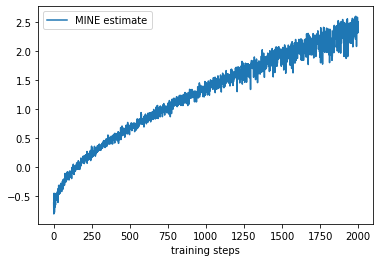

In [57]:
H=200
n_epochs = 2000

# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, n_hidden], name='x_in')
y_in = tf.placeholder(tf.float32, [None, n_hidden], name='y_in')

# make the loss and optimisation graphs
neg_loss, opt = MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []
for epoch in range(n_epochs):
    
    # perform the training step
    feed_dict = {x_in:quant_zq[:-1,:], y_in:zq_sample[1:,:]}
    _, neg_l = sess.run([opt, neg_loss], feed_dict=feed_dict)
    
    if epoch % 100 == 0:
        print("epoch: ",epoch, "neg_l: ",neg_l)
    
    # save the loss
    MIs.append(-neg_l)

fig, ax = plt.subplots()
ax.plot(range(len(MIs)), MIs, label='MINE estimate')
ax.set_xlabel('training steps')
ax.legend(loc='best')
#fig.savefig('MINE.png')
fig.show()

zq_sample are the samples of latent states of the original sequence. The probability distribution of zq_sample is given by N(zq_mu,zq_sigma).

quant_zq are the rate reduced versions of the latent states.  The bit-rate reduction bring the samples closer to mean at low rate. At high rate it transmits the samples with zero added noise. 

We calculate I(Z,Y) by approximation I(Z,T_fullrate). These are both gaussian variables.
We know only their marginal distributions, so we need to estimate a joint distribution between
past values of bit-reduced representaiton and future value of full rate.

### The process of VMO modeling is repeated here for noisy (bit limited) version of latent states

In [169]:
import vmo
r = (0., 2.0, 0.01)
#ideal_t = vmo.find_threshold(quant_zq.T, r = r, dfunc = 'euclidean', dim=quant_zq.shape[0])
ideal_t = vmo.find_threshold(quant_zq, flag = 'a', r = r, dim=quant_zq.shape[1])

71.81489950679291


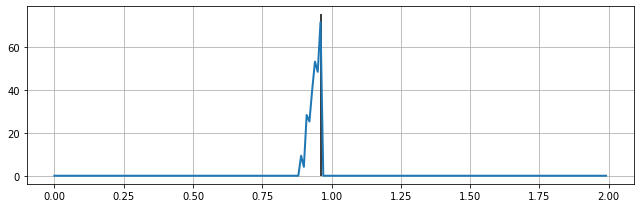

In [170]:
x_t = np.array([t[1] for t in ideal_t[1]])
y_t = [t[0] for t in ideal_t[1]] 
plt.figure(figsize = (9,3))
plt.plot(x_t, y_t, linewidth = 2)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t[0][1], 0, ymax)
plt.grid('on')
plt.tight_layout()
print(ideal_t[0][0])

In [171]:
best_oracle = vmo.build_oracle(quant_zq, flag = 'a', threshold = ideal_t[0][1], dim=quant_zq.shape[1])

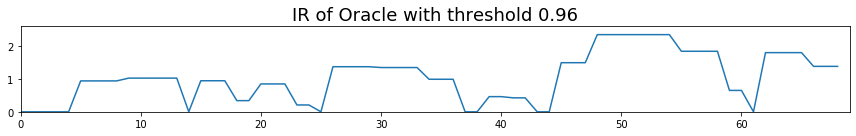

In [172]:
ir, h0, h1 = best_oracle.IR()
plt.figure(figsize=(12,2))
plt.plot(ir)
plt.ylim((0, max(ir) + 0.25))
plt.xlim((0, len(ir)))
plt.title('IR of Oracle with threshold' + ' ' + str(ideal_t[0][1]), fontsize=18)
plt.tight_layout()

In [383]:
import vmo.analysis as van
import vmo.generate as vge

bo = best_oracle

seq_i = vge.improvise(bo, seq_len = 120, LRS = 2, weight = 'lrs') #weight='weight' , seq_len = len(quant_zq)
b, kend, ktrace = vge.generate(bo, 120, 0.87, 1, LRS=2, weight='weight')
seq = [quant_zq[i-1] for i in b]

In [384]:
# Decode with the z from query
#samples = sess.run(X_samples, feed_dict={z: zq_sample})
samples = sess.run(X_samples, feed_dict={z: seq})
decode_bars = len(samples)
S = np.reshape(samples, (decode_bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
print(Rate)
fname = 'out/generated_query_h500_nt16_'+str(Rate)
#fname = 'out/generated_query_h3000_nt16_'+str(Rate)
midi_manipulation.noteStateMatrixToMidi(thresh_S,fname )    

100


In [385]:
help(vmo.build_oracle)

Help on function build_oracle in module vmo.VMO.oracle:

build_oracle(input_data, flag='a', threshold=0, suffix_method='inc', feature=None, weights=None, dfunc='cosine', dfunc_handle=None, dim=1)



## IR as function of Bit-Rate 

In [666]:
Rates = np.power(2,range(10))*5 #1.45 for h=3000 (908 max rate), 1.4 for h=500 (556 max rate)

In [667]:
Rates = np.rint(Rates).astype(int)
Rates

array([   5,   10,   20,   40,   80,  160,  320,  640, 1280, 2560])

In [668]:
#Reading a Song from Songs
#song = songs[2]
#song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
#song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
#print(np.shape(song))

#Creating a latent space sequence from the song using pretrained VAE
#Xq = song
#zq_mu, zq_logvar = sess.run([z_mu, z_logvar], feed_dict={X: Xq}) 
#zq_sample = sess.run(z_sample, feed_dict={X: Xq}) 

In [674]:
#test_songs = get_songs('./LABROSA-APT/test/MIDI')
test_songs = get_songs('./LABROSA-APT/train/MIDI')
num_songs = len(test_songs)
num_songs


100%|██████████| 19/19 [00:06<00:00,  2.88it/s]


19

In [675]:
import vmo
r = (0., 2.0, 0.01)

num_songs = len(test_songs)
IR = np.zeros((len(Rates),num_songs))
IT = np.zeros((len(Rates),num_songs))

for j,song in enumerate(test_songs):
    if j == 5:
        continue
    print('Processing song ',j)
    song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
    song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
    Xq = song
    zq_sample, zq_mu, zq_logvar = sess.run([z_sample, z_mu, z_logvar], feed_dict={X: Xq}) #encode song into z
    zq_sig2 = np.mean(np.exp(zq_logvar), axis = 0) #obtain the sig2 of each z for that song
    for i,R in enumerate(Rates):
        print(i,R)
        bit_alloc = reverse_water_filling(zq_sig2,R)  #computer bit allocation for that song
        quant_zq = Berger(zq_sample, bit_alloc)  #quantize z with limited bit-rate
        ideal_t = vmo.find_threshold(quant_zq, flag = 'a', r = r, dim=quant_zq.shape[1])
        IT[i,j] = ideal_t[0][1]
        IR[i,j] = ideal_t[0][0]


Processing song  0
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  1
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  2
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  3
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  4
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  6
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  7
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  8
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  9
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  10
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  11
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  12
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  13
0 5
1 10
2 20
3 40
4 80
5 160
6 320
7 640
8 1280
9 2560
Processing song  14
0

In [676]:
help(vmo.find_threshold)

Help on function find_threshold in module vmo.VMO.oracle:

find_threshold(input_data, r=(0, 1, 0.1), method='ir', flag='a', suffix_method='inc', alpha=1.0, feature=None, ir_type='cum', dfunc='cosine', dfunc_handle=None, dim=1, verbose=False, entropy=False)



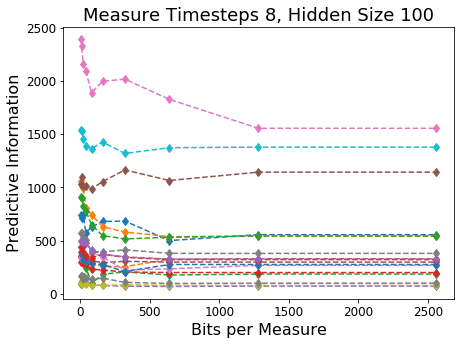

In [677]:
#print(num_songs)
for k in range(num_songs):
    if all(IR[:,k] != 0):
#        print('OK',k)
        plt.plot(Rates,IR[:,k],'d--')

#plt.plot(Rates,np.mean(IR,1))
#plt.yscale('log')
   
ttl = 'Measure Timesteps '+str(num_timesteps)+', Hidden Size '+str(n_hidden)
    
#num_timesteps  = 16 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
#n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
#n_hidden       = 3000 #500  #50 #This is the size of the hidden layer
#plt.rcParams.update({'font.size': 12})

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 16 #10
BIGGER_SIZE = 18

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.gcf()
plt.title(ttl)
plt.ylabel('Predictive Information')
plt.xlabel('Bits per Measure')
fig.set_size_inches(7, 5.0)
figname = 'IRt'+str(num_timesteps)+'h'+str(n_hidden)+'.png'
fig.savefig(figname, dpi=100)

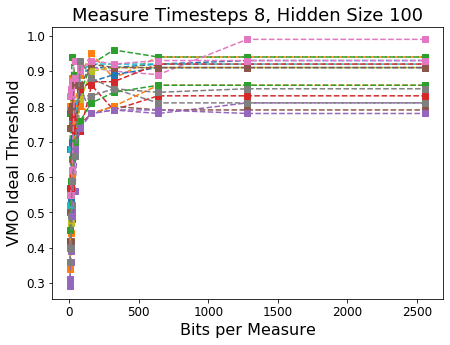

In [678]:
for k in range(num_songs):
    if all(IT[:,k] != 0):
#        print('OK',k)
        plt.plot(Rates,IT[:,k],'s--')
        
ttl = 'Measure Timesteps '+str(num_timesteps)+', Hidden Size '+str(n_hidden)
    
#num_timesteps  = 16 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
#n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
#n_hidden       = 3000 #500  #50 #This is the size of the hidden layer
#plt.rcParams.update({'font.size': 12})

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 16 #10
BIGGER_SIZE = 18

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.gcf()
plt.title(ttl)
plt.ylabel('VMO Ideal Threshold')
plt.xlabel('Bits per Measure')
fig.set_size_inches(7, 5.0)
figname = 'ITt'+str(num_timesteps)+'h'+str(n_hidden)+'.png'
fig.savefig(figname, dpi=100)

### END

(1073, 156)
(33, 4992)
(50,)
100
[0. 0. 0. ... 0. 0. 0.]
42.58002066214208
300
[0. 0. 0. ... 0. 0. 0.]
44.37158646596499
500
[0. 1. 0. ... 0. 0. 0.]
53.05434130023223
700
[0. 1. 0. ... 0. 0. 0.]
47.60768257722124
900
[0. 1. 1. ... 0. 0. 1.]
45.7388394745043
1100
[0. 1. 1. ... 1. 0. 1.]
61.82231015850013
1300
[0. 1. 1. ... 1. 0. 1.]
44.40235215672305
1500
[0. 1. 1. ... 1. 0. 1.]
49.7832100691347
1700
[0. 1. 1. ... 1. 0. 1.]
51.87827737074174
1900
[0. 1. 1. ... 1. 0. 1.]
43.87071698305503
2100
[0. 1. 1. ... 1. 0. 1.]
45.022720076500086
2300
[0. 1. 1. ... 1. 0. 1.]
33.12927150442428
2500
[1. 1. 1. ... 1. 0. 1.]
46.63248808203622
2700
[1. 1. 1. ... 1. 1. 1.]
32.19740565229373
2900
[1. 1. 1. ... 1. 1. 1.]
35.90060523956273
3100
[1. 1. 1. ... 1. 1. 1.]
29.415037499278842
3300
[1. 1. 1. ... 1. 1. 1.]
41.437757575778924
3500
[1. 2. 1. ... 1. 1. 1.]
33.49477950108393
3700
[1. 2. 1. ... 1. 1. 1.]
40.87071698305504
3900
[1. 2. 2. ... 1. 1. 2.]
31.836335130728195
4100
[1. 2. 2. ... 2. 1. 2.]
29.86

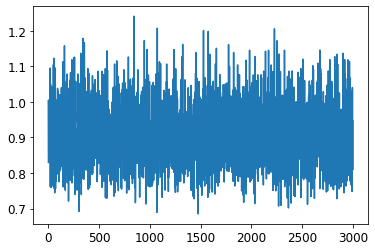

In [310]:
Rate = [r for r in range(100,10000,200)]
IR = np.zeros(np.shape(Rate))
IT = np.zeros(np.shape(Rate))
q = "./Naruto Shippuden OP 16 COMP - C maj.mid"
#q = "./tmprson3.mid"
#q = "./Naruto Shippuden OP 16 COMP.mid"
#q = "./Pop_Music_Midi/All The Small Things - Verse.midi"
song = np.array(midi_manipulation.midiToNoteStateMatrix(q))
print(song.shape)
song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
Xq = song
print(Xq.shape)
zq_mu, zq_logvar = sess.run([z_mu, z_logvar], feed_dict={X: Xq}) #encode song into z
zq_sig2 = np.mean(np.exp(zq_logvar), axis = 0) #obtain the sig2 of each z for that song
plt.plot(zq_sig2)
zq_sample = sess.run(z_sample, feed_dict={X: Xq}) #sample new z's for that song

print(np.shape(IR))
for i,R in enumerate(Rate):
    print(R)
    bit_alloc = reverse_water_filling(zq_sig2,R)  #computer bit allocation for that song
    print(bit_alloc)
    quant_zq = Berger(zq_sample, bit_alloc)  #quantize z with limited bit-rate
    ideal_t = vmo.find_threshold(quant_zq, flag = 'a', r = r, dim=quant_zq.shape[1])
    #IR[i,j] = ideal_t[0][0]
    print(ideal_t[0][0])
    IR[i] = ideal_t[0][0]
    IT[i] = ideal_t[0][1]

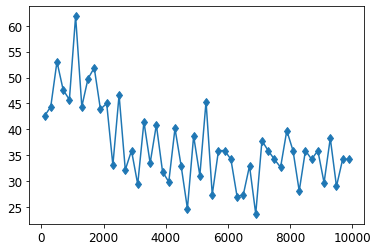

In [316]:
plt.plot(Rate,IR,'d-')

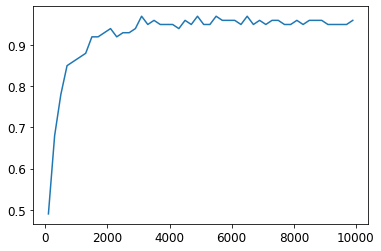

In [315]:
plt.plot(Rate,IT)